<a href="https://colab.research.google.com/github/focussed/etivity1/blob/master/Etivity3_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity 3

Welcome to etivity3,
The overall goal here is to run up the different algorithms found in by research at the start of this week and to comapre the cluster plots for each of the algorithms.

The algorithms being uses here are:


*   DBScan
*   Means shifting clustering
*   Gaussian mixture modelling

Finally, we model the dataset for the well known k-means algorithm and suggest a suitable value for k.

## Evaluation of other clustering algorithms
The nominations for best alternative clustering algorithm are:

1.   Means shifting clustering
This works akin to a TCP sliding window, for those experienced in networking.  Candidates for the next best centroid point are based on the mean distances between all points within the window.  The big advantage over k means clustering is there is no need to select the number of clusters as the algorithm does it.

2.   DBScan
This is similar to the means shifting clustering algorithm as it does not need you to select the number of clusters and also, it handles outliers as noise.  It is not great with clusters of different densities.

3.   Gaussian Mixture Models
This algorihm uses the mean AND the standard deviation values to estimate the shape and size of the clusters.  Knowing statistics, this make me more happier as I know they better describe the data.

## Best k Means value for the loans dataset



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

In [178]:
url_train = 'https://raw.githubusercontent.com/focussed/etivity1/master/loans_train_prepared.csv'
df = pd.read_csv(url_train, index_col=0)
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 15)


### Rescaling
There is no need to rescale this dataset as it is all in normalised form (0..1)

Setup the plot definitions

In [0]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## Set the k means value

In [0]:
k = 3

In [0]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

In [0]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]  

In [183]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


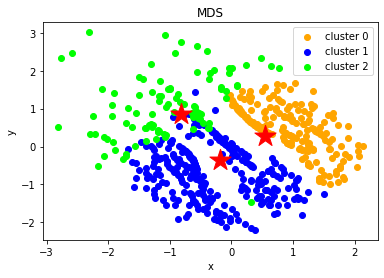

In [184]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

Apply t-SNE 

In [185]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


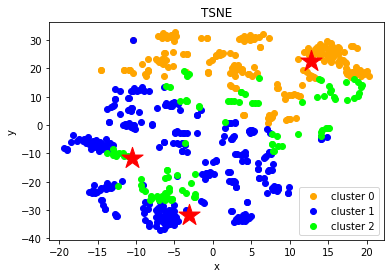

In [186]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

In [0]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [188]:
df.head()

,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,cluster
Dependents,,,,,,,,,,,,,,,,
0.000000,1.084523,1.058140,0.75,1,1,0,0,0,0,0,0,0,1,1,0.841086,1
0.333333,0.925883,1.047319,0.75,1,1,0,1,0,0,0,0,0,0,0,0.871711,1
0.000000,0.683858,0.635920,0.75,1,1,0,1,0,1,0,0,0,1,1,0.385189,1
0.000000,0.608992,1.002824,0.75,1,1,0,1,0,0,0,1,0,1,1,0.717012,1
0.000000,1.101869,1.115650,0.75,1,1,0,0,0,0,0,0,0,1,1,0.860305,1


In [189]:
df.groupby('cluster').mean()

,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
cluster,,,,,,,,,,,,,,,
0,0.816979,1.033096,0.722512,0.872038,0.739336,0.018957,0.649289,0.009479,0.113744,0.042654,0.213270,1.00,0.000000,0.772512,0.759537
1,0.766483,0.971804,0.706436,0.838284,0.825083,0.013201,0.640264,0.003300,0.082508,0.066007,0.287129,0.00,0.534653,0.640264,0.702573
2,1.581583,1.483606,0.715000,0.870000,0.830000,0.050000,0.670000,0.000000,0.330000,0.030000,0.020000,0.22,0.400000,0.650000,1.565471


# Setting k to a larger value


### DBScan algorithm


Estimated number of clusters: 3
Estimated number of noise points: 474
Silhouette Coefficient: -0.075


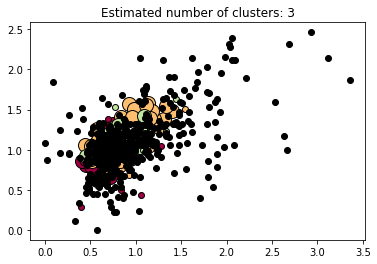

In [190]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
X = data

db = DBSCAN(eps=0.5, min_samples=15).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()



